<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/face_detection/face_detection/Face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Kat-ies/Coursework.git
%cd Coursework/src
%run for_google_drive.py

In [ ]:
from data_loader import unpacking_zips

unpacking_zips()

# Шаг 1.
Сделаем свой класс, который красиво склеит мои картинки и рамки из прошлой работы и подсунет их торчу в том виде, в котором ему надо (интернет сказал, что именно таким способом предобученным моделям подают свои датасеты). 

P.S. поскольку идеи я брала из уже готовых реализаций, то часть параметров мне показалась лишней (вроде как в target  им сеткам нужны только boxes и labels), и я закомментила всё, что посчитала лишним. 


тут вроде всё работает, только я не доконца разобралась с transform, я так поняла, что в примерах дополнительно подключают [такой модуль](https://github.com/pytorch/vision/blob/master/references/detection/transforms.py), но я не знаю, нужен ли он мне, если не поворачивать изображения, поэтому я в transform я засунула только конвертацию изображения в тензор и нормализацию. 

In [ ]:
from PIL import Image 
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MyDataset(Dataset):
    def __init__(self, images, frames, transforms=None):
        self.images = images
        self.frames = frames
        self.keys_list = list(images.keys())
        self.transforms = transforms
 
    def __getitem__(self, idx):
        img = self.images[self.keys_list[idx]]

        boxes = []
        labels = np.ones(len(self.frames[self.keys_list[idx]]))

            
        for rects in self.frames[self.keys_list[idx]]:
            boxes.append([rects.x, rects.y, rects.x + rects.w, rects.y + rects.h])
                
        boxes = torch.as_tensor(boxes, dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)   
             
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
 
        if self.transforms is not None:
            # Note that target (including bbox) is also transformed\enhanced here, which is different from transforms from torchvision import
            # Https://github.com/pytorch/vision/tree/master/references/detectionOfTransforms.pyThere are examples of target transformations when RandomHorizontalFlip
            # img, target = self.transforms(img, target)
            img = self.transforms(img)
 
        return img, target
 
    def __len__(self):
        return len(self.images)


In [ ]:
train_transforms = transforms.Compose(
[# transforms.RandomHorizontalFlip(),
 transforms.ToTensor(),
 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from images_and_frames import *


# поскольку картинки и рамки я уже когда-то юзала, то можно снова взять эти функции
dict_images = make_images_dict(is_color=True, max_dict_size= 2000)
dict_frames = make_frames_dict(dict_images)

keys_list = list(dict_frames.keys())
for key in keys_list:
    for rects in dict_frames[key]:
        if rects == Rectangle(0,0,0,0) or rects.w == 0 or rects.h == 0:
            if key in dict_frames:
                del dict_frames[key]
            if key in dict_images:
                del dict_images[key]

train_dataset = MyDataset(dict_images, dict_frames, transforms=train_transforms)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=20,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn)

# на вид вывод похож на правду
# train_dataset[0]

# Finetuning 
Может не с первого раза, но с этой частью я разобралась. Если я всё праивльно поняла, то моя задача заменить число классов выходного слоя (1 класс + фон, т.е всего 2 класса) и дообучить модель на датасете, где все labels будут 1. 

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
      
def get_object_detection_model():
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # replace the classifier with a new one, that has num_classes which is user-defined
    num_classes = 2  # 1 + background
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
 

In [ ]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_object_detection_model()
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


# Дообучение модели 

Настройка всех параметров завершена, поэтому осталось только сделать `train` и наслаждаться жизнью. 

Я могла бы сделать это вручную, но у торча есть прекрасный гитхаб с полезными функциями, которые выводят даже какую-то статистику (в принципе можно ещё график построить, как в прошлый раз). Поэтому я взяла всё нужное где-то тут https://github.com/pytorch/vision и сохранила отдельным файлом.

Я не писала всё сама, тк подумала, что если всё же получится потренировать сетки в Google Cloud, то там можно будет попробовать понастраивать какие-нибудь параметры, которые в колабе недоступны (например, число  gpu). А сделать эти настройки в готовой функции проще, чем в своей собственной :)


In [ ]:
import math

num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=50)
    lr_scheduler.step()

torch.save(model.state_dict(), "model.bin")

No traceback available to show.


Epoch: [0]  [  0/999]  eta: 0:21:03  lr: 0.000010  loss: 2.2680 (2.2680)  loss_classifier: 0.9615 (0.9615)  loss_box_reg: 0.1696 (0.1696)  loss_objectness: 0.8161 (0.8161)  loss_rpn_box_reg: 0.3208 (0.3208)  time: 1.2652  data: 0.2606  max mem: 2348
Epoch: [0]  [ 50/999]  eta: 0:08:56  lr: 0.000260  loss: 1.0804 (1.3534)  loss_classifier: 0.3063 (0.3997)  loss_box_reg: 0.1762 (0.1638)  loss_objectness: 0.3405 (0.4580)  loss_rpn_box_reg: 0.3091 (0.3319)  time: 0.5649  data: 0.0062  max mem: 6114
Epoch: [0]  [100/999]  eta: 0:08:46  lr: 0.000511  loss: 0.9662 (1.2015)  loss_classifier: 0.2909 (0.3520)  loss_box_reg: 0.2315 (0.1989)  loss_objectness: 0.2132 (0.3670)  loss_rpn_box_reg: 0.1571 (0.2836)  time: 0.6208  data: 0.0069  max mem: 6114
Epoch: [0]  [150/999]  eta: 0:08:22  lr: 0.000761  loss: 1.2726 (1.1638)  loss_classifier: 0.3223 (0.3298)  loss_box_reg: 0.4994 (0.2603)  loss_objectness: 0.1937 (0.3126)  loss_rpn_box_reg: 0.1721 (0.2612)  time: 0.6088  data: 0.0060  max mem: 9715


# **О боже оно работает!!!**

Что делать, если в 5 утра заработала нейронка? - Конечно же, поиграться с ней и попрогонять все картинки, что есть под рукой!

*P.S. я, конечно, могу сказать, что все снимки ниже подобраны так, чтобы посмотреть разные случаи и всё такое, но фраза "посмотрите, что у меня есть" прозвучит куда убедительнее :)*  

*P.P.S. я ещё решила повыводить `score`, потому что во время самой первой попытки на снимке со мной была рамочка у меня и возле меня. Только вот там никого не было...*  



In [ ]:
import os

PATH = '/content/drive/MyDrive/КУ Курсачи/Курсовая работа 2021/images'
files = os.listdir(PATH)

images = []
predictions = []

for file in files:
    image = Image.open(os.path.join(PATH, file))
    img = train_transforms(image)
    images.append(image)

    model.eval()
    with torch.no_grad():
       prediction = model([img.to(device)])
    predictions.append(prediction)

In [138]:
from PIL import Image, ImageDraw 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


def show_predictions(images, predictions, titles):

    fig = plt.figure(figsize=(60, 70))
    cols = 1
    rows = len(images)

    # ax enables access to manipulate each of subplots
    ax = []
    i = 0
   
    for image, prediction, title in zip(images, predictions, titles):

        boxes = list(prediction[0]['boxes'].cpu().numpy())
        scores = list(prediction[0]['scores'].cpu().numpy())
        

        ax.append(fig.add_subplot(rows, cols, i + 1))
        ax[-1].set_title(title)
        i += 1

        for box, score in zip(boxes, scores):
            img1 = ImageDraw.Draw(image)   
            img1.rectangle(box, fill =None, outline ="red") 

            img2 = ImageDraw.Draw(image)
            img2.rectangle((box[0],box[1],box[0]+65,box[1]+14), fill ='black', outline ="black") 

            img3 = ImageDraw.Draw(image)
            img3.text((box[0],box[1]),'score: '+f"{score:.{2}f}")


        plt.imshow(image)

    plt.show()  # finally, render the plot


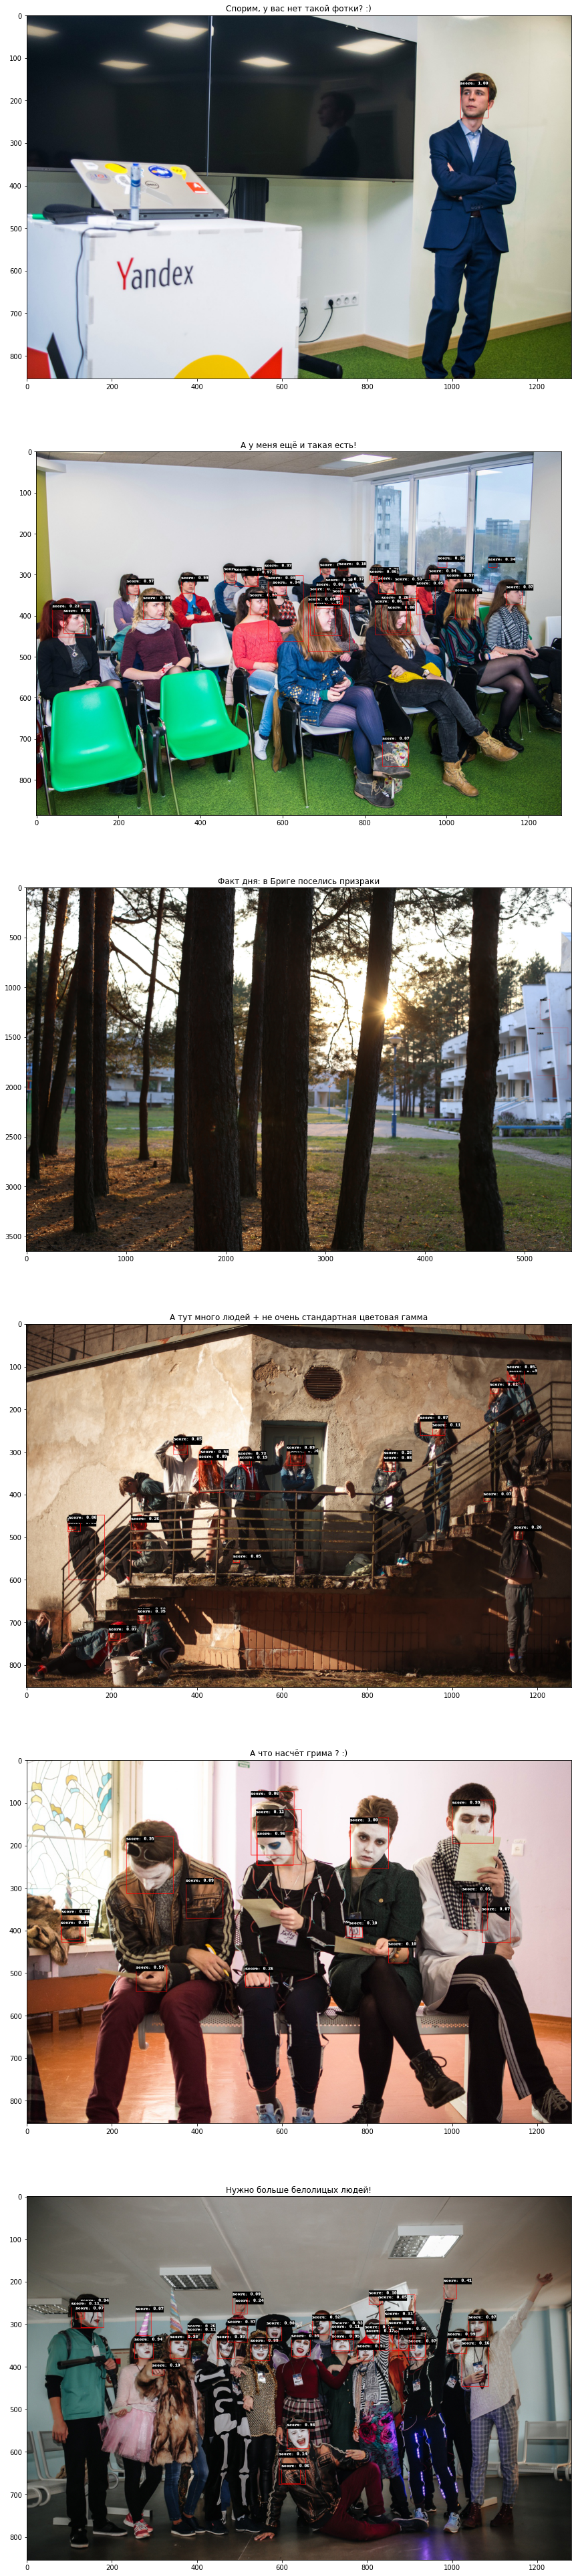

In [141]:
show_predictions(images, predictions, titles)

# Ниже можно не смотреть.
Там пока лежат скопипасченные функции, которые я потом зашью в отдельные файлы. Пока пусть тут полежат :)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Mar 14 23:30:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W /  70W |   1222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from collections import defaultdict, deque
import datetime
import pickle
import time

import torch
import torch.distributed as dist

import errno
import os


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
           print("Loss is {}, stopping training".format(loss_value))
           print(loss_dict_reduced)
            #sys.exit(1)
           break

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [140]:
titles = [
          'Спорим, у вас нет такой фотки? :)',
          'А у меня ещё и такая есть!',
          'Факт дня: в Бриге поселись призраки',
          'А тут много людей + не очень стандартная цветовая гамма',
          'А что насчёт грима ? :)',
          'Нужно больше белолицых людей!',
]